In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-11 16:10:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-11 16:10:07 (73.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# 101 Food classes

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-03-09 10:11:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  68.9MB/s    in 30s     

2024-03-09 10:12:06 (52.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a big model with transfer learning

* Create ModelCheckpoint callback
* Create data augmentation layer to build right into the model
* Build a headless (no top layers) Functional EfficientNetB0 model
* Compile the model
* Feature extract for 5 epochs (and evaluate on 15% of test_data to save time)

In [ ]:
# Creating a ModelCheckpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_chekpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horzontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)
], name="data_augmentation")

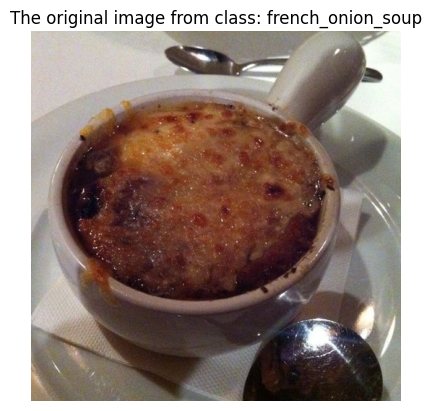

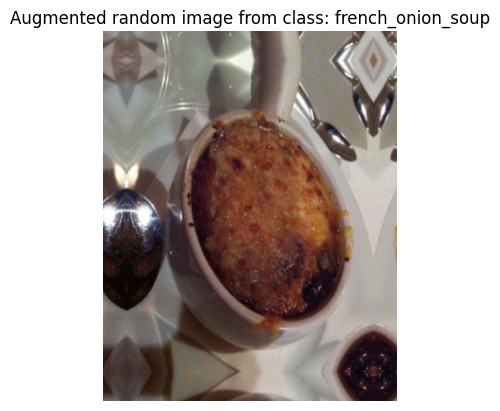

In [ ]:
# View a random image and view its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names)
target_dir = "101_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"The original image from class: {target_class}")
plt.axis(False);

# Read and plot augmented random image
plt.figure()
augmented_image = data_augmentation(img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(augmented_image)

In [ ]:
# Set up the base model and freeze its layers

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="Input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="Output_layer")(x)
model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compile our model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

initial_epochs = 5

history = model.fit(train_data_10_percent,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 204s 806ms/step - loss: 3.5374 - accuracy: 0.2404 - val_loss: 2.6585 - val_accuracy: 0.4462
Epoch 2/5
237/237 [==============================] - 131s 551ms/step - loss: 2.4248 - accuracy: 0.4494 - val_loss: 2.1634 - val_accuracy: 0.4995
Epoch 3/5
237/237 [==============================] - 105s 439ms/step - loss: 2.0497 - accuracy: 0.5146 - val_loss: 1.9526 - val_accuracy: 0.5254
Epoch 4/5
237/237 [==============================] - 100s 419ms/step - loss: 1.8435 - accuracy: 0.5599 - val_loss: 1.8793 - val_accuracy: 0.5294
Epoch 5/5
237/237 [==============================] - 83s 348ms/step - loss: 1.6997 - accuracy: 0.5840 - val_loss: 1.8285 - val_accuracy: 0.5389


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 54s 68ms/step - loss: 1.6102 - accuracy: 0.5791


[1.6101576089859009, 0.5791287422180176]

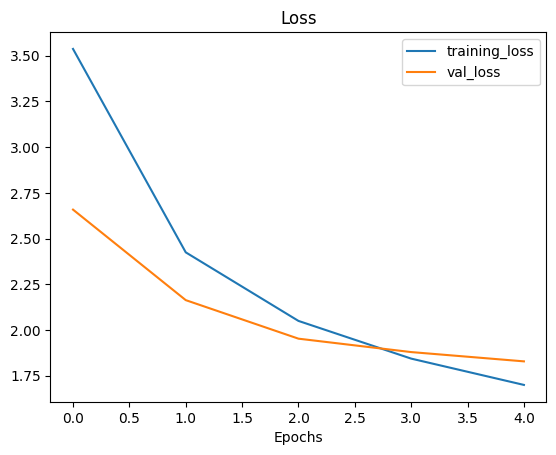

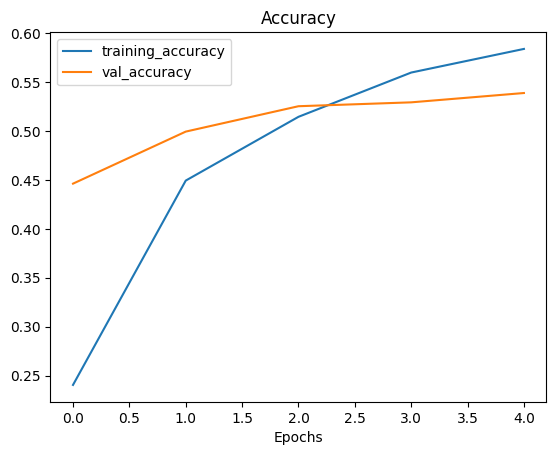

In [ ]:
plot_loss_curves(history)

### Fine Tuning the Model

In [ ]:
# Unfreeze all of the layers in base model
base_model.trainable = True

# Refreeze every layer except the last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile the model (lower the learning_rate)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layer models are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
Output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [ ]:
history_fine_tune = model.fit(train_data_10_percent,
                              epochs=initial_epochs + 5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 80s 306ms/step - loss: 1.4739 - accuracy: 0.6276 - val_loss: 1.7811 - val_accuracy: 0.5323
Epoch 6/10
237/237 [==============================] - 69s 288ms/step - loss: 1.3847 - accuracy: 0.6481 - val_loss: 1.7554 - val_accuracy: 0.5405
Epoch 7/10
237/237 [==============================] - 64s 268ms/step - loss: 1.3401 - accuracy: 0.6524 - val_loss: 1.7547 - val_accuracy: 0.5429
Epoch 8/10
237/237 [==============================] - 62s 259ms/step - loss: 1.2851 - accuracy: 0.6642 - val_loss: 1.7190 - val_accuracy: 0.5469
Epoch 9/10
237/237 [==============================] - 65s 271ms/step - loss: 1.2299 - accuracy: 0.6747 - val_loss: 1.7352 - val_accuracy: 0.5453
Epoch 10/10
237/237 [==============================] - 56s 233ms/step - loss: 1.2113 - accuracy: 0.6808 - val_loss: 1.7216 - val_accuracy: 0.5477


In [ ]:
# Evaluate on the whole test_data dataset
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 51s 65ms/step - loss: 1.4798 - accuracy: 0.6025


[1.4797536134719849, 0.6024554371833801]

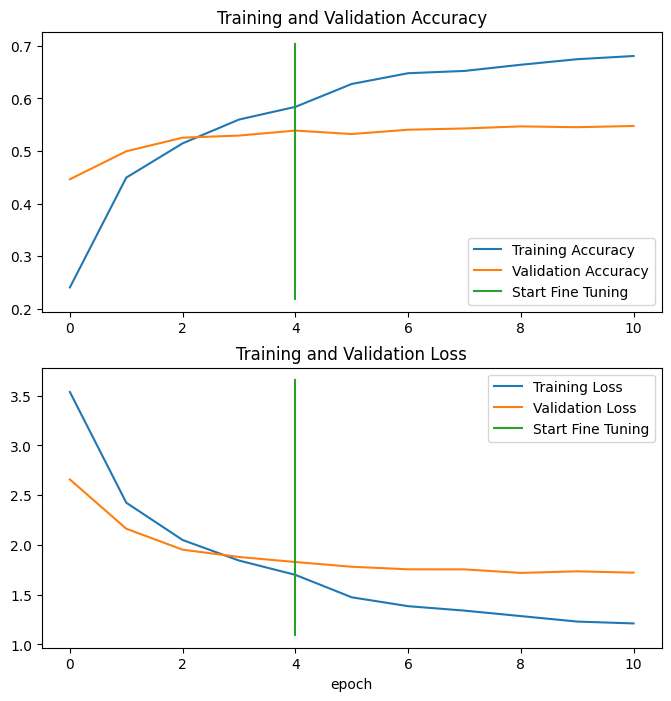

In [ ]:
# Compare the histories
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=initial_epochs)

## Saving and loading our model

To use our model in an external application, we need to save it and export it somewhere

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Save our model
model.save("drive/MyDrive/101_food_classes_10_percent_saved_model")

In [ ]:
# Download pre-trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-03-09 10:34:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 173.194.203.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   117MB/s    in 0.4s    

2024-03-09 10:34:52 (117 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 71ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

### Making predictions with trained model


In [ ]:
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left



790/790 [==============================] - 59s 73ms/step


In [ ]:
len(test_data)

790

In [ ]:
len(preds_probs)

25250

In [ ]:
# The shape of predictions
preds_probs.shape

(25250, 101)

In [ ]:
# Checking the first ten predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
# What the first prediction probability look like
preds_probs[0], len(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

In [ ]:
print(f"Number of probabilities for sample 0: {len(preds_probs[0])}")
print(f" What prediction probability sample 0 looks like:\n {preds_probs[0]} ")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of probabilities for sample 0: 101
 What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-05 1.28526

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
len(pred_classes)

25250

### Comparing our model's predictions with original test dataset labels

In [ ]:
# Unbatch <Unravel> the test_data dataset and turn it into array
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Evaluating our model's predictions array is in the same order as test order array is to find the accuracy score

In [ ]:
# Trying sklearn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

### Making a confusion matrix

In [ ]:
# Getting a list of class names
class_names = test_data.class_names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# make_confusion_matrix(y_true=y_labels,
#                       y_pred=pred_classes,
#                       classes=class_names,
#                       figsize=(150, 150),
#                       text_size=25)